In [1]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import *
from keras.models import Model, load_model, Sequential
import cv2
from tqdm import tqdm
import keras

Using TensorFlow backend.


## Open dataset

In [5]:
# Open all 
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)


In [6]:
X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 2.5 Hz
X = X[::2]
Y = Y[::2]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))

Shape X (93054,)
Shape Y (93054,)


## Open images

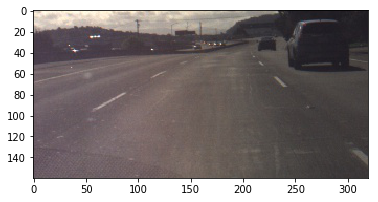

In [7]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filename = lane1['filenames'].iloc[0]
img = np.array(image.load_img(filename))
plt.imshow(img)

In [8]:
def get_optical_flow(frame1, frame2):
    '''Frame1: previous frame
       Frame2: last frame
       Returns: Polar optical flow in RBG'''
    
    prev = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Get present frame
    next_ = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    hsv[...,0] = ang*180/np.pi/2

    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

In [9]:

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[3])) # previous
frame2 = np.array(cv2.imread(lane1['filenames'].iloc[4])) # present

flow1 = get_optical_flow(frame1, frame2) # 4-3

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[2])) # previous

flow2 = get_optical_flow(frame1, frame2) # 4-2

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[1])) # previous

flow3 = get_optical_flow(frame1, frame2) # 4-1

frame1 = np.array(cv2.imread(lane1['filenames'].iloc[0])) # previous

flow4 = get_optical_flow(frame1, frame2) # 4-0


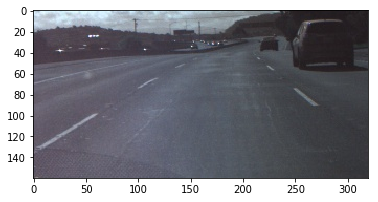

In [10]:
plt.imshow(frame2)

Text(0.5,1,'Flow t-1')

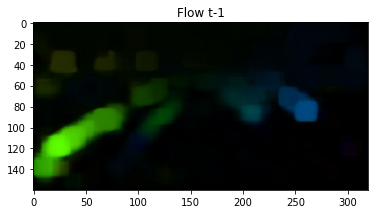

In [11]:
plt.imshow(flow1)
plt.title('Flow t-1')

Text(0.5,1,'Flow t-2')

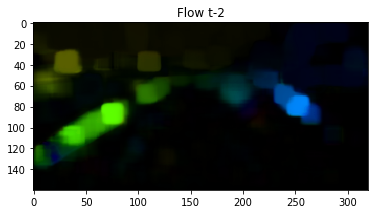

In [12]:
plt.imshow(flow2)
plt.title('Flow t-2')

Text(0.5,1,'Flow t-3')

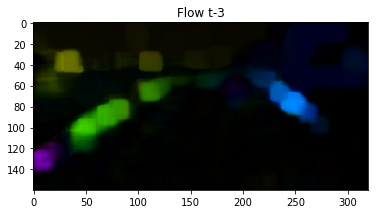

In [13]:
plt.imshow(flow3)
plt.title('Flow t-3')

Text(0.5,1,'Flow t-4')

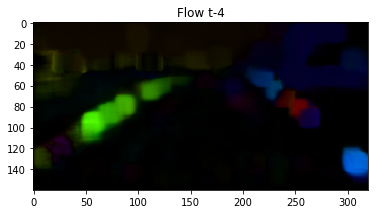

In [15]:
plt.imshow(flow4)
plt.title('Flow t-4')

## Flow pre-processing
    - Cut to 100 pixels?  Tested, does not help.
    - Quo Vadis norm? Not the problem.
    - Average flow? Could be
    - Multiplication ? Could be
    - Stack? Could be
    - T-? Il faut!

### Option T-?

In [42]:
def baseline(input_shape=(160,320,3), dropout=0.1):
    """
   Classic NVIDIA model.
    """
    model = Sequential()
    
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input_shape))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2), input_shape=input_shape))
    #model.add(BatchNormalization())

    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    #model.add(BatchNormalization())

    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())
    
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss=rmse)
    #model.compile(optimizer='SGD', momentum=0.9, weight_decay=)
    #model.summary()

    return model


from keras.utils import Sequence
class Batch_generator(Sequence):
    '''Generates batches of images and labels on the fly from disc. 
    Uses process_line() function to perform image reading transformation.
    x_set: Numpy array with filenames (strings)
    y_set: Numpy array with binary gender labels (0,1)
    batch_size: Number of samples per batch
    '''
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

        return np.array([process_line(file_name)
                   for file_name in batch_x]), batch_y.astype('float32')


def process_line(filename):
    '''Process one line of the batch directory.------------------------
     Read a list of two filenames: previous - current.
     Returns the optical flow !!
    '''
    frame1 = np.array(cv2.imread(filename[0])) # previous
    frame2 = np.array(cv2.imread(filename[1])) # present
    flow = get_optical_flow(frame1, frame2) # flow present vs previous 
    
    return frame1, flow  


def get_index(X, Y, offset=4):
    new_X = []
    new_Y = []
    for i in range(int(X.shape[0]-offset)):
        pair_X = [X[i], X[i + offset]]
        new_X.append(pair_X)
        new_Y.append(Y[i + offset])
        
    return np.array(new_X), np.array(new_Y)


def rmse(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1)) 


### Option T-1 using the Spatial Baseline model

In [17]:
new_X, new_Y = get_index(X, Y, offset=1)

In [18]:
# Load data on RAM

# Normalize target
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(new_Y.reshape(-1,1))

new_y = scaler.transform(new_Y.reshape(-1,1)) #y minuscule est normalisé


# Suffle examples
import random
proportion = 1
# Generate a random selection of indexes
indexes = random.sample(range(0, new_X.shape[0]), int(new_X.shape[0]*proportion))

# Select desired examples
shuffle_X = new_X[indexes]
shuffle_Y = new_y[indexes].astype('float32') # Already normalized


In [19]:
X_train = []
X_train2 = []
for element in tqdm(shuffle_X):
    # Get current frame and optical flow
    current, flow = process_line(element)
    X_train.append(flow)
    X_train2.append(current)

train1 = np.array(X_train) 
train2 = np.array(X_train2)   

100%|██████████| 93053/93053 [28:39<00:00, 54.12it/s]


In [20]:
train1 = train1.reshape(-1,160,320,3)

In [23]:
# Create baseline
flow_model = baseline()

In [24]:
# Configure Keras Callbacks
model_name = 'flownnorm_check.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history = flow_model.fit(train1, shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=64
            )    



Train on 32568 samples, validate on 13958 samples
Epoch 1/100
32568/32568 [==============================] - 94s 3ms/step - loss: 0.2213 - val_loss: 0.1525

Epoch 00001: val_loss improved from inf to 0.15251, saving model to flownnorm_check.hdf5
Epoch 2/100
32568/32568 [==============================] - 94s 3ms/step - loss: 0.1403 - val_loss: 0.1413

Epoch 00002: val_loss improved from 0.15251 to 0.14133, saving model to flownnorm_check.hdf5
Epoch 3/100
32568/32568 [==============================] - 94s 3ms/step - loss: 0.1242 - val_loss: 0.1294

Epoch 00003: val_loss improved from 0.14133 to 0.12945, saving model to flownnorm_check.hdf5
Epoch 4/100
32568/32568 [==============================] - 95s 3ms/step - loss: 0.1126 - val_loss: 0.1338

Epoch 00004: val_loss did not improve from 0.12945
Epoch 5/100
32568/32568 [==============================] - 95s 3ms/step - loss: 0.1033 - val_loss: 0.1239

Epoch 00005: val_loss improved from 0.12945 to 0.12391, saving model to flownnorm_check.h

In [32]:
def plot_train_loss(history):
  
  #plt.plot(history.history['acc'])
  #plt.plot(history.history['val_acc'])
  #plt.title('model accuracy')
  #plt.ylabel('accuracy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
    
    
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plt.style.use('ggplot')



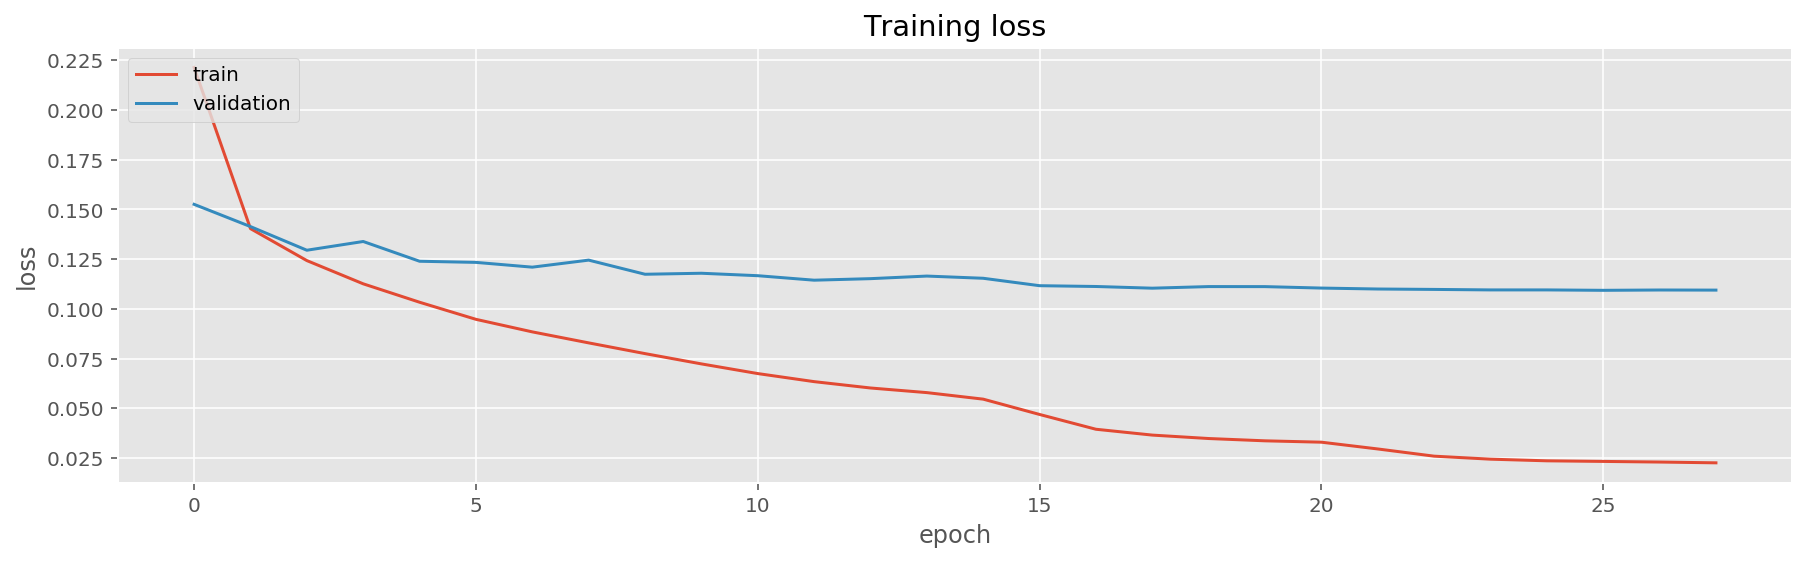

In [28]:
plot_train_loss(history)

In [29]:
def temporal_net(input_shape=(160,320,3), dropout=0.2):
    """
   Classic NVIDIA model.
    """
    model = Sequential()
    
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input_shape))
    model.add(Conv2D(96, (7, 7), activation='relu', strides=(2, 2), input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    #model.add(BatchNormalization())

    model.add(Conv2D(256, (5, 5), activation='relu', strides=(2, 2)))
    model.add(MaxPool2D((2,2)))

    #model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1)))
    #model.add(BatchNormalization())

    model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1)))
    #if input_shape[0] != 100:
    model.add(MaxPool2D((2,2)))


    #model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())

    #model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))

    #model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss=rmse)
    #model.compile(optimizer='SGD', momentum=0.9, weight_decay=)
    #model.summary()

    return model

In [83]:
# Crop images
crop_train = [(lambda x:x[40:,:])(x) for x in train1]

In [62]:
temp = temporal_net(input_shape=(160,320,3))

In [32]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history = temp.fit(train1, shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=64
            )    


Train on 32568 samples, validate on 13958 samples
Epoch 1/100
32568/32568 [==============================] - 159s 5ms/step - loss: 0.1555 - val_loss: 0.1604

Epoch 00001: val_loss improved from inf to 0.16040, saving model to flownnorm_check_temp.hdf5
Epoch 2/100
32568/32568 [==============================] - 158s 5ms/step - loss: 0.1417 - val_loss: 0.1478

Epoch 00002: val_loss improved from 0.16040 to 0.14777, saving model to flownnorm_check_temp.hdf5
Epoch 3/100
32568/32568 [==============================] - 158s 5ms/step - loss: 0.1310 - val_loss: 0.1346

Epoch 00003: val_loss improved from 0.14777 to 0.13462, saving model to flownnorm_check_temp.hdf5
Epoch 4/100
32568/32568 [==============================] - 158s 5ms/step - loss: 0.1225 - val_loss: 0.1290

Epoch 00004: val_loss improved from 0.13462 to 0.12896, saving model to flownnorm_check_temp.hdf5
Epoch 5/100
32568/32568 [==============================] - 158s 5ms/step - loss: 0.1152 - val_loss: 0.1250

Epoch 00005: val_loss 

# Crop tempnet

In [72]:
np.shape(train1)

(56255, 160, 320, 3)

In [73]:
np.shape(crop_train)

(56255, 100, 320, 3)

In [84]:
temp = baseline(input_shape=(120,320,3), dropout=0.1)

In [85]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp_crop.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history = temp.fit(np.array(crop_train), shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=128
            )    

Train on 39378 samples, validate on 16877 samples
Epoch 1/100
39378/39378 [==============================] - 83s 2ms/step - loss: 0.2306 - val_loss: 0.1808

Epoch 00001: val_loss improved from inf to 0.18085, saving model to flownnorm_check_temp_crop.hdf5
Epoch 2/100
39378/39378 [==============================] - 81s 2ms/step - loss: 0.1687 - val_loss: 0.1645

Epoch 00002: val_loss improved from 0.18085 to 0.16447, saving model to flownnorm_check_temp_crop.hdf5
Epoch 3/100
39378/39378 [==============================] - 82s 2ms/step - loss: 0.1520 - val_loss: 0.1578

Epoch 00003: val_loss improved from 0.16447 to 0.15783, saving model to flownnorm_check_temp_crop.hdf5
Epoch 4/100
39378/39378 [==============================] - 81s 2ms/step - loss: 0.1397 - val_loss: 0.1511

Epoch 00004: val_loss improved from 0.15783 to 0.15109, saving model to flownnorm_check_temp_crop.hdf5
Epoch 5/100
39378/39378 [==============================] - 81s 2ms/step - loss: 0.1291 - val_loss: 0.1501

Epoch 0

KeyboardInterrupt: 

In [91]:
temp = baseline(input_shape=(160,320,3), dropout=0.3)

In [92]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp_crop.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history = temp.fit(np.array(train1), shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=128
            )    

Train on 39378 samples, validate on 16877 samples
Epoch 1/100
39378/39378 [==============================] - 112s 3ms/step - loss: 0.2187 - val_loss: 0.1485

Epoch 00001: val_loss improved from inf to 0.14854, saving model to flownnorm_check_temp_crop.hdf5
Epoch 2/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1432 - val_loss: 0.1355

Epoch 00002: val_loss improved from 0.14854 to 0.13553, saving model to flownnorm_check_temp_crop.hdf5
Epoch 3/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1313 - val_loss: 0.1288

Epoch 00003: val_loss improved from 0.13553 to 0.12885, saving model to flownnorm_check_temp_crop.hdf5
Epoch 4/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1207 - val_loss: 0.1255

Epoch 00004: val_loss improved from 0.12885 to 0.12554, saving model to flownnorm_check_temp_crop.hdf5
Epoch 5/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1128 - val_loss: 0.1252

Ep

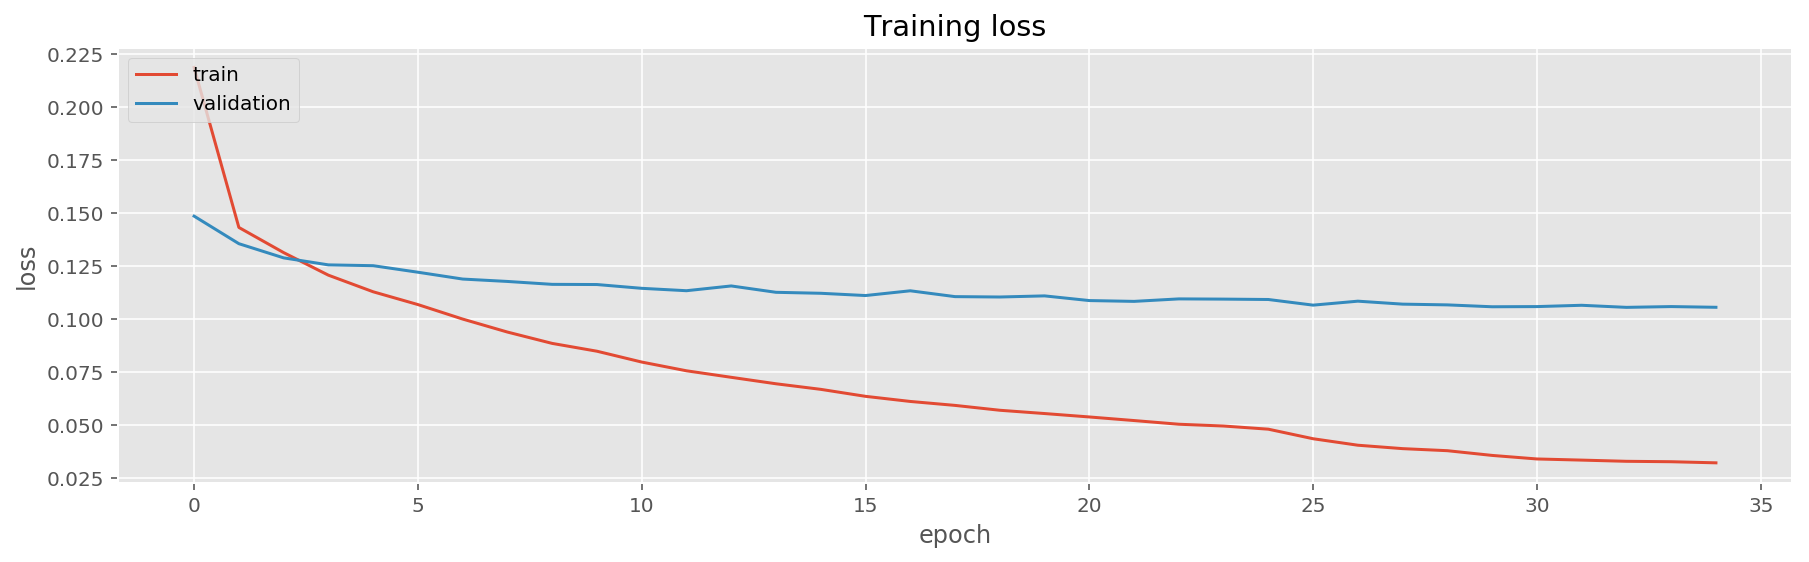

In [97]:
plot_train_loss(history)

In [93]:
temp = baseline(input_shape=(160,320,3), dropout=0.5)

In [94]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp_50.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history2 = temp.fit(np.array(train1), shuffle_Y, 
             shuffle=True, epochs=100,
             #validation_data = ([val_X1, val_X2]),
             validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=128
            )    

Train on 39378 samples, validate on 16877 samples
Epoch 1/100
39378/39378 [==============================] - 112s 3ms/step - loss: 0.2192 - val_loss: 0.1489

Epoch 00001: val_loss improved from inf to 0.14886, saving model to flownnorm_check_temp_50.hdf5
Epoch 2/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1479 - val_loss: 0.1375

Epoch 00002: val_loss improved from 0.14886 to 0.13748, saving model to flownnorm_check_temp_50.hdf5
Epoch 3/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1362 - val_loss: 0.1311

Epoch 00003: val_loss improved from 0.13748 to 0.13115, saving model to flownnorm_check_temp_50.hdf5
Epoch 4/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1278 - val_loss: 0.1258

Epoch 00004: val_loss improved from 0.13115 to 0.12577, saving model to flownnorm_check_temp_50.hdf5
Epoch 5/100
39378/39378 [==============================] - 111s 3ms/step - loss: 0.1213 - val_loss: 0.1248

Epoch 0000

39378/39378 [==============================] - 111s 3ms/step - loss: 0.0434 - val_loss: 0.1014

Epoch 00043: val_loss improved from 0.10148 to 0.10140, saving model to flownnorm_check_temp_50.hdf5
Epoch 00043: early stopping


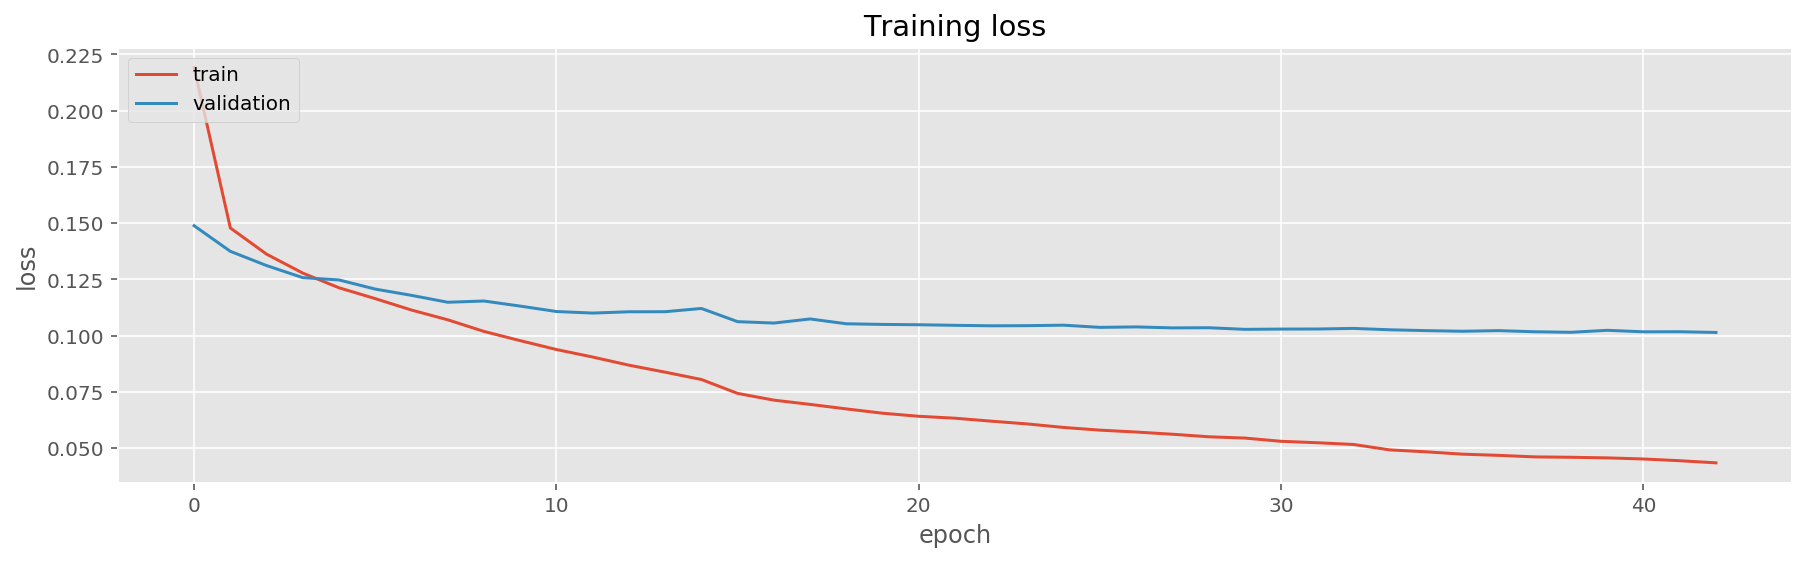

In [96]:
plot_train_loss(history2)

## 2D with more data and the best config found

In [21]:
temp = baseline(input_shape=(160,320,3), dropout=0.5)

In [26]:
train1 = np.array(train1)

In [ ]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp_50_all.hdf5'
min_delta=.0005
patience = 5

X_train = train1[:75000]
Y_train = shuffle_Y[:75000]

X_val = train1[75000:89000]
Y_val = shuffle_Y[75000:89000]

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history2 = temp.fit(X_train,Y_train, 
             shuffle=True, epochs=100,
             validation_data = (X_val, Y_val),
             #validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=100
            )    

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 187s 2ms/step - loss: 0.1314 - val_loss: 0.1297

Epoch 00001: val_loss improved from inf to 0.12975, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 2/100
75000/75000 [==============================] - 187s 2ms/step - loss: 0.1162 - val_loss: 0.1122

Epoch 00002: val_loss improved from 0.12975 to 0.11224, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 3/100
75000/75000 [==============================] - 187s 2ms/step - loss: 0.1075 - val_loss: 0.1053

Epoch 00003: val_loss improved from 0.11224 to 0.10531, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 4/100
75000/75000 [==============================] - 186s 2ms/step - loss: 0.1009 - val_loss: 0.1030

Epoch 00004: val_loss improved from 0.10531 to 0.10305, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 5/100
75000/75000 [==============================] - 187s 2ms/step - loss: 0.0954 - val_loss: 0.

75000/75000 [==============================] - 188s 3ms/step - loss: 0.0361 - val_loss: 0.0743

Epoch 00043: val_loss improved from 0.07507 to 0.07434, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 44/100
75000/75000 [==============================] - 188s 3ms/step - loss: 0.0356 - val_loss: 0.0748

Epoch 00044: val_loss did not improve from 0.07434
Epoch 45/100
75000/75000 [==============================] - 188s 3ms/step - loss: 0.0352 - val_loss: 0.0739

Epoch 00045: val_loss improved from 0.07434 to 0.07388, saving model to flownnorm_check_temp_50_all.hdf5
Epoch 46/100
75000/75000 [==============================] - 188s 3ms/step - loss: 0.0348 - val_loss: 0.0746

Epoch 00046: val_loss did not improve from 0.07388
Epoch 47/100
75000/75000 [==============================] - 187s 2ms/step - loss: 0.0347 - val_loss: 0.0743

Epoch 00047: val_loss did not improve from 0.07388
Epoch 48/100
75000/75000 [==============================] - 188s 3ms/step - loss: 0.0342 - val_loss: 0.07

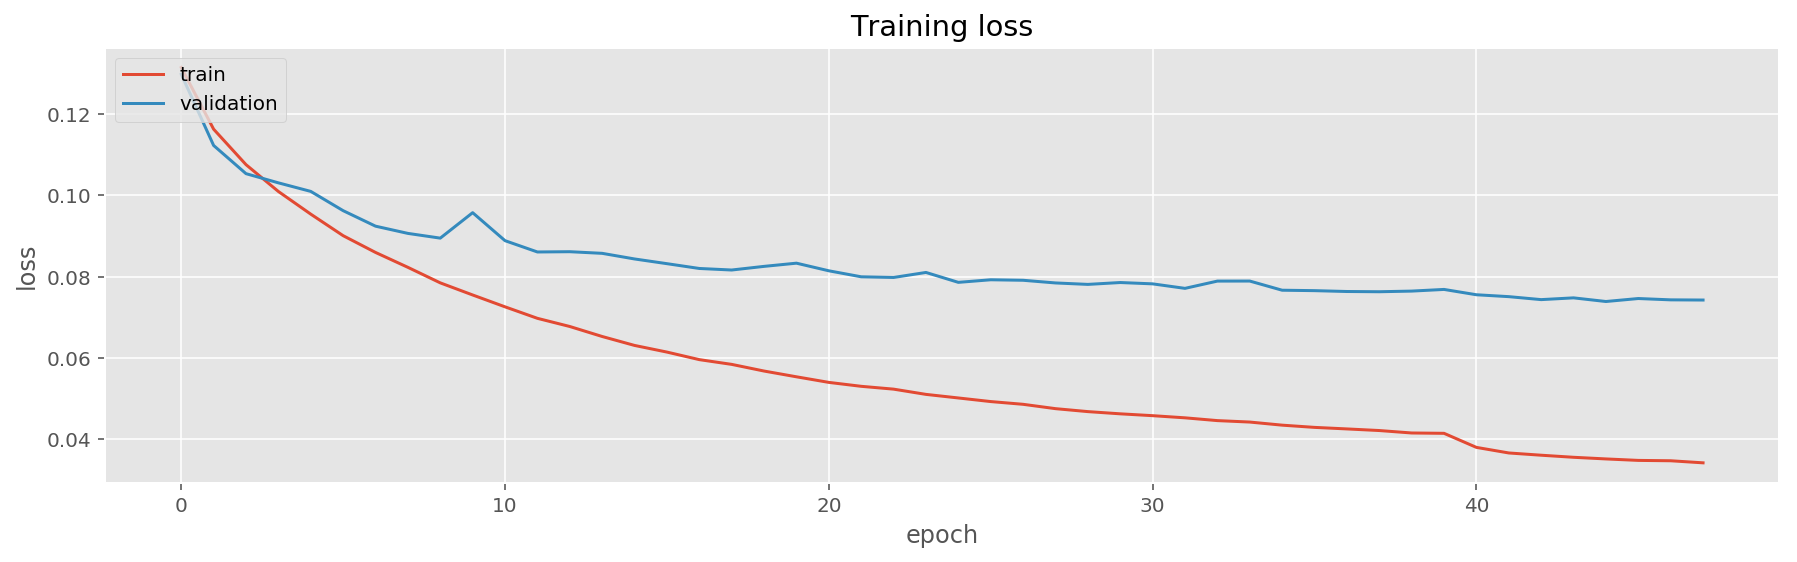

In [33]:
plot_train_loss(history2)

## FlowNet

In [30]:
net =  temporal_net()

In [34]:
# Configure Keras Callbacks
model_name = 'flownnorm_check_temp_50_all_flow.hdf5'
min_delta=.0005
patience = 5

X_train = train1[:75000]
Y_train = shuffle_Y[:75000]

X_val = train1[75000:89000]
Y_val = shuffle_Y[75000:89000]

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


# Training step
# Train1 and train2 are already shuffled
history3 = net.fit(X_train,Y_train, 
             shuffle=True, epochs=100,
             validation_data = (X_val, Y_val),
             #validation_split = 0.3,
             callbacks = [early_stop, reduce_LR, snapshot],
             batch_size=100
            )    

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 336s 4ms/step - loss: 0.2114 - val_loss: 0.1415

Epoch 00001: val_loss improved from inf to 0.14150, saving model to flownnorm_check_temp_50_all_flow.hdf5
Epoch 2/100
75000/75000 [==============================] - 331s 4ms/step - loss: 0.1313 - val_loss: 0.1201

Epoch 00002: val_loss improved from 0.14150 to 0.12009, saving model to flownnorm_check_temp_50_all_flow.hdf5
Epoch 3/100
75000/75000 [==============================] - 331s 4ms/step - loss: 0.1184 - val_loss: 0.1134

Epoch 00003: val_loss improved from 0.12009 to 0.11343, saving model to flownnorm_check_temp_50_all_flow.hdf5
Epoch 4/100
75000/75000 [==============================] - 330s 4ms/step - loss: 0.1096 - val_loss: 0.1098

Epoch 00004: val_loss improved from 0.11343 to 0.10982, saving model to flownnorm_check_temp_50_all_flow.hdf5
Epoch 5/100
75000/75000 [==============================] - 330s 4ms/step - loss: 0

KeyboardInterrupt: 

# Flow + Spatial Network

In [39]:
import tensorflow
import keras
keras.__version__

'2.2.0'

In [40]:
tensorflow.__version__

'1.8.0'

In [65]:
# Load spatial Network
spatial = load_model('checkpoint_nvidia_model.hdf5', custom_objects={'rmse': rmse})

# Load flow Network
flow = load_model('flownnorm_check_temp_50_all.hdf5', custom_objects={'rmse': rmse})


# Prepare test set

In [48]:
X_test = train1[89000:]
Y_test = shuffle_Y[89000:]

In [49]:
print('X test', np.shape(X_test))
print('Y test', np.shape(Y_test))

X test (4053, 160, 320, 3)
Y test (4053, 1)


In [50]:
# Compute predictions of flow model
flow_pred = flow.predict(X_test)

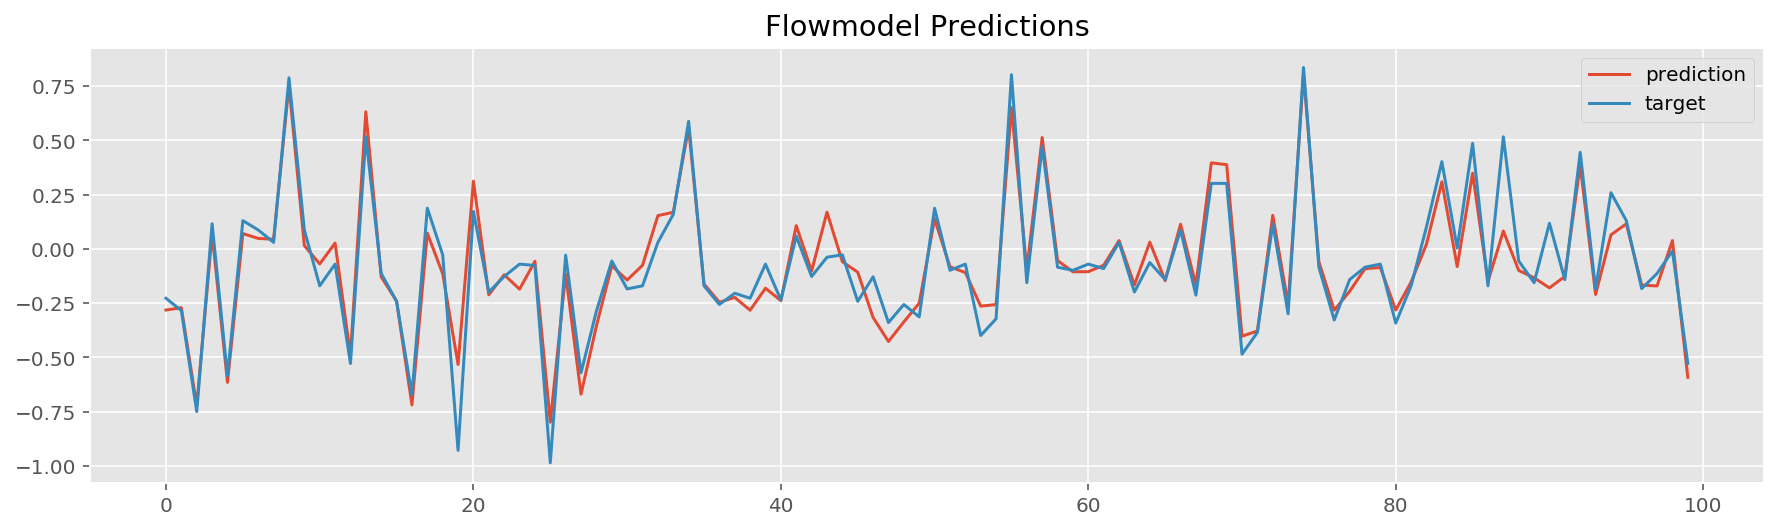

In [60]:
plt.plot(flow_pred[:100], label='prediction')
plt.plot(Y_test[:100], label='target')
plt.title('Flowmodel Predictions')
plt.legend()

In [55]:
flow_X = []
current_X = []
for element in tqdm(shuffle_X[89000:]):
    # Get current frame and optical flow
    current, flow = process_line(element)
    flow_X.append(flow)
    current_X.append(current)

flow_X = np.array(flow_X) 
current_X = np.array(current_X)   

100%|██████████| 4053/4053 [01:13<00:00, 54.81it/s]


In [57]:
# Evaluate models
spatial_pred = spatial.predict(current_X)

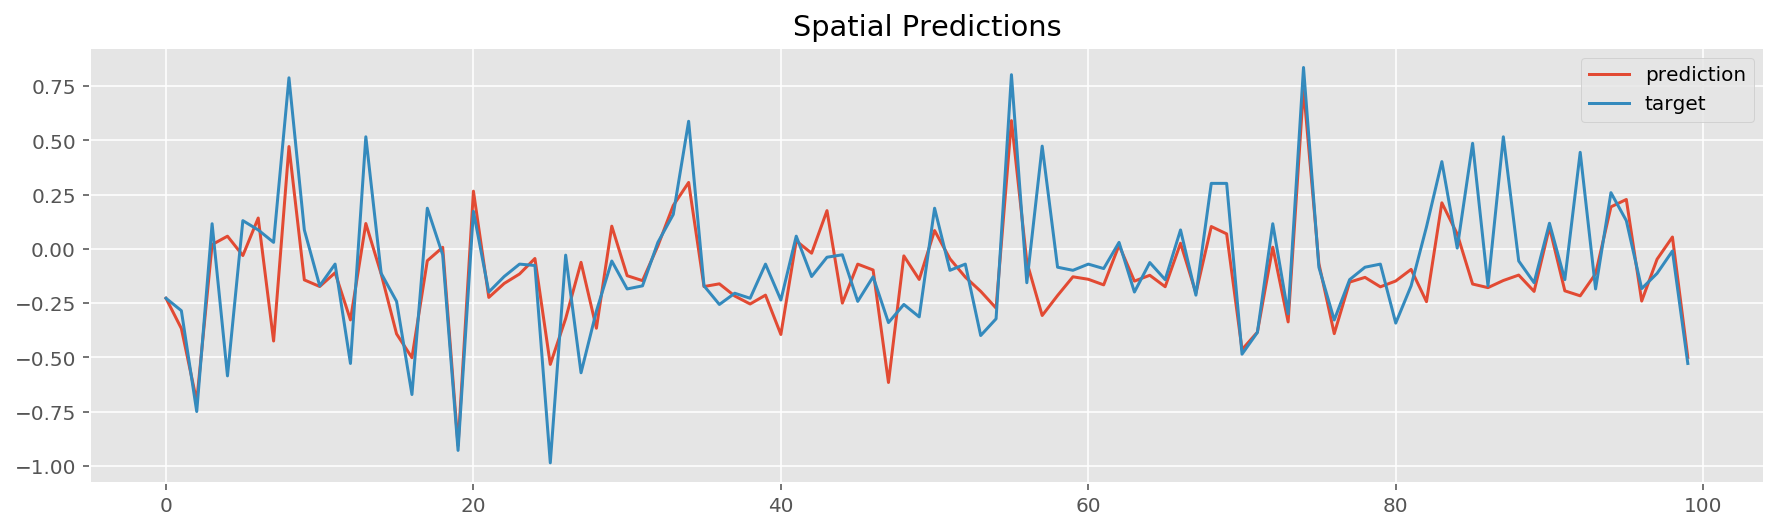

In [61]:
plt.plot(spatial_pred[:100], label='prediction')
plt.plot(Y_test[:100], label='target')
plt.title('Spatial Predictions')
plt.legend()

### The predictions are somehow complementary
    - Flow model overperform the spatial model on the test set ! --- Probably, because of the higher Dropout (0.5vs0.1)

In [62]:
spatial.evaluate(current_X, Y_test)

4053/4053 [==============================] - 5s 1ms/step


0.1289091885031049

In [66]:
flow.evaluate(flow_X, Y_test)

4053/4053 [==============================] - 5s 1ms/step


0.07373332287936983

## Create a MLP at the top of the two models
     - The input is (spatial_pred, flow_pred).
     - Retrain on the same training data 
     - Test on the test data
     - IT would be nice to retrain with different DATA

In [75]:
def load_im(filename):
    '''Process one line of the batch directory.------------------------
     Read a list of two filenames: previous - current.
     Returns the optical flow !!
    '''
    #frame1 = np.array(cv2.imread(filename[0])) # previous
    frame2 = np.array(cv2.imread(filename[1])) # present
    #flow = get_optical_flow(frame1, frame2) # flow present vs previous 
    
    return frame2#, flow  


In [76]:
# Load all current images to get the predictions from the Spatial model
#X_train = []

X_train_current = []
for element in tqdm(shuffle_X):
    # Get current frame and optical flow
    current= load_im(element)
    #X_train.append(flow)
    X_train_current.append(current)

X_train_current = np.array(X_train_current) 
#train2 = np.array(X_train2)  

100%|██████████| 93053/93053 [01:13<00:00, 1260.78it/s]


In [77]:
# Compute predictions from the spatial and flow model on the TRAINING /  VAL set

X_train_spatial_MLP = spatial.predict(X_train_current)
X_train_spatial_FLOW = flow.predict(train1)

In [78]:
# Create training pairs 
MLP_train_X = []
for x, y in zip(X_train_spatial_MLP, X_train_spatial_FLOW):
    MLP_train_X.append([x, y])
    
MLP_train_X = np.array(MLP_train_X)

np.shape(MLP_train_X)

(93053, 2, 1)

In [85]:
MLP_train_X = MLP_train_X.reshape(-1,2)

In [107]:
from keras.optimizers import SGD

mlp = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
mlp.add(Dense(128, activation='relu', input_dim=2))
mlp.add(Dense(64, activation='relu', input_dim=2))
mlp.add(Dropout(0.5))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(1, activation='tanh'))

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(loss=rmse,
              optimizer=sgd)


model_name = 'mlp_final_tanh.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')


history3 = mlp.fit(MLP_train_X[:75000], Y_train,
        validation_data=(MLP_train_X[75000:89000], Y_val),
          epochs=100,
          batch_size=128,
          callbacks = [early_stop, reduce_LR, snapshot]
        )


#score = model.evaluate(x_test, y_test, batch_size=128)

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 3s 44us/step - loss: 0.2043 - val_loss: 0.1765

Epoch 00001: val_loss improved from inf to 0.17650, saving model to mlp_final_tanh.hdf5
Epoch 2/100
75000/75000 [==============================] - 2s 30us/step - loss: 0.1624 - val_loss: 0.1405

Epoch 00002: val_loss improved from 0.17650 to 0.14048, saving model to mlp_final_tanh.hdf5
Epoch 3/100
75000/75000 [==============================] - 2s 30us/step - loss: 0.1409 - val_loss: 0.1231

Epoch 00003: val_loss improved from 0.14048 to 0.12307, saving model to mlp_final_tanh.hdf5
Epoch 4/100
75000/75000 [==============================] - 2s 30us/step - loss: 0.1294 - val_loss: 0.1143

Epoch 00004: val_loss improved from 0.12307 to 0.11429, saving model to mlp_final_tanh.hdf5
Epoch 5/100
75000/75000 [==============================] - 2s 30us/step - loss: 0.1213 - val_loss: 0.1086

Epoch 00005: val_loss improved from 0.11429 to 0.10

In [108]:
test_pred = mlp.predict(MLP_train_X[89000:])

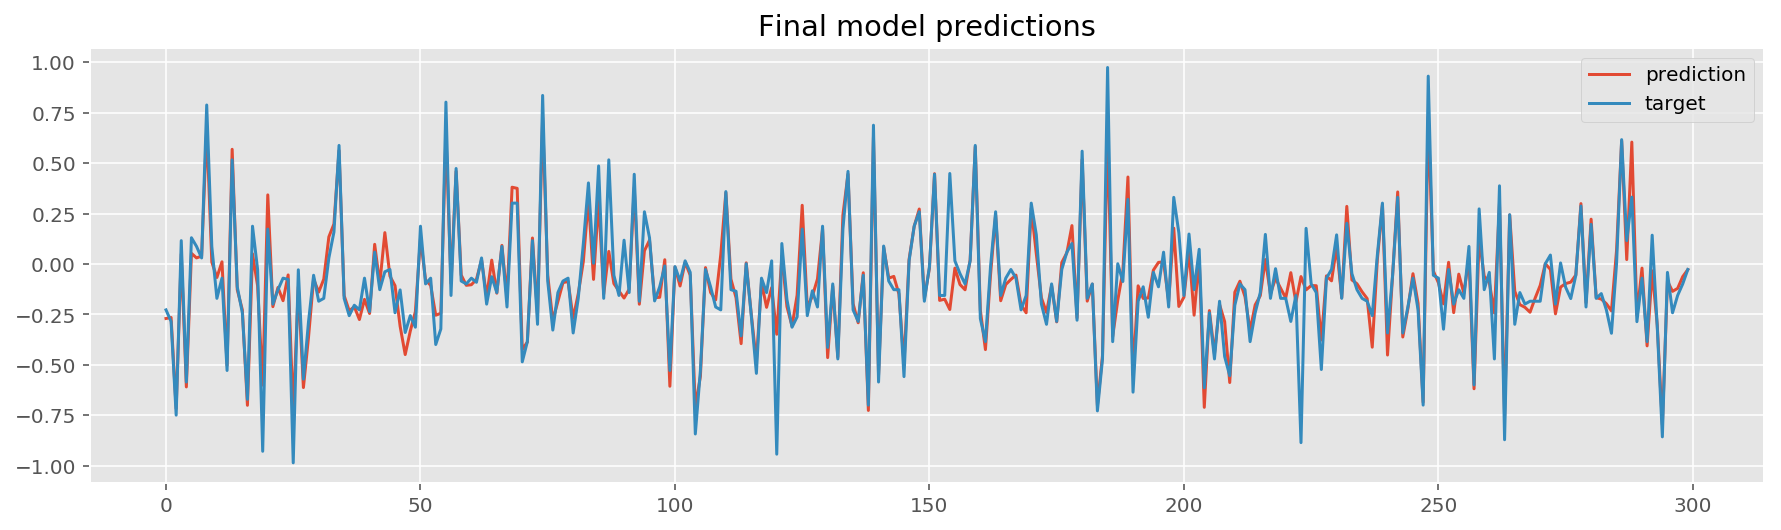

In [119]:
plt.plot(test_pred[:300], label='prediction')
plt.plot(Y_test[:300], label='target')
plt.title('Final model predictions')
plt.legend()

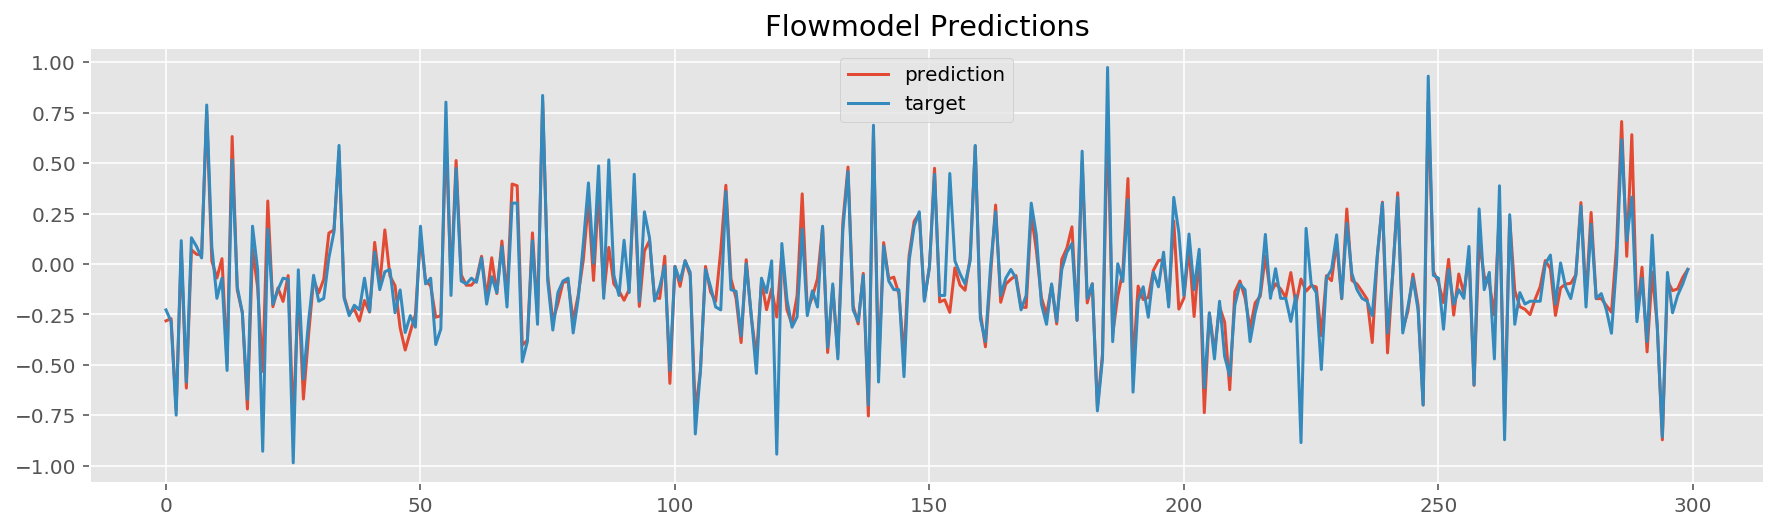

In [120]:
plt.plot(flow_pred[:300], label='prediction')
plt.plot(Y_test[:300], label='target')
plt.title('Flowmodel Predictions')
plt.legend()

In [102]:
from sklearn.metrics import mean_squared_error

In [114]:
# Final model Error
mean_squared_error(Y_test, test_pred)

0.012599231

In [115]:
# Optical model error
mean_squared_error(Y_test, flow_pred)

0.012890219

In [116]:
# Spatial model error
mean_squared_error(Y_test, spatial_pred)

0.040443417

# Conclusion:
    - Juntar un modelo bueno con uno peor, da uno peor, o no mucho mejor a uno de los 2
    - En clasificacion de video, parece logico entrenarlos por separado, en regresion, no parece ayudar.
    - Con todo lo aprendido, ahora intenta entrenar un modelo todos juntos.
    - Tambien puedes probar con tensores de optical flow en vez de solo imagenes.
    - Las features de la images y del optical flow parecen complementarias, porque el carro hace lo mismo casi todo el tiempo. Es mas facil entender el optical flow, porque la CNN se enfoca en aprender solo lo que se movio, que normalmente son las lineas.
    - Hay diferencias con respecto a la clasificacion de videos:
        1 = Los optical flows no son tan variados ! las dos redes aprenden cosas similares.
        2 = En la clasificacion se hace una media de las probabilidades, que parecen describir facetas diferentes del clip. Estas features distintas estan aseguradas con el entrenamiento en dos redes aparte.
        3 = En la regresion, un valor incorrecto tiende a danar la precision del mejor de los modelos. Pequenos valores de error son importantes.
        4 = Es mejor entrenar los dos flow juntos, de manera de que todos los pesos se ajusten adecuadamente para la regresion.
        